<a href="https://colab.research.google.com/github/keerthanmahesh/Code-Mixed-Sarcasm-Detection/blob/master/Code_Mixed_Sarcasm_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
import nltk
from nltk.corpus import stopwords 
import re
import string
from itertools import groupby
from collections import Counter
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from fuzzywuzzy import process

In [ ]:
pip install fuzzywuzzy

In [ ]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# sarcasm data
with open('/content/drive/My Drive/Data Files/code-mixed analysis data/Sarcasm_tweets.txt') as f:
   lines = [line.rstrip() for line in f]

new_lines = []
for line in lines:
    if line == '':
        continue
    new_lines.append(line)

tweet_ids = []
tweets = []

for i in range(len(new_lines)):
    if i%2 == 0:
        tweet_ids.append(new_lines[i])
    else:
        tweets.append(new_lines[i])


# annotations
with open('/content/drive/My Drive/Data Files/code-mixed analysis data/Sarcasm_tweet_truth.txt') as f1:
   lines1 = [line.rstrip() for line in f1]

labels = []

for i in range(len(lines1)):
    if i%2 != 0:
        labels.append(lines1[i])


# tweets with language
f2 = open('/content/drive/My Drive/Data Files/code-mixed analysis data/Sarcasm_tweets_with_language.txt', 'r')
tokens_list = []
tokens = []
languages_list = []
languages = []
for line in f2:
    line = line.strip()
    line = line.split(' ')
    line = [token.strip() for token in line if token != '' and  token != ' ' and token != '\n']
    if len(line) == 0:
        tokens_list.append(tokens)
        languages_list.append(languages)
        tokens = []
        languages = []
    elif len(line) == 1:
        continue
    else:
        tokens.append(line[0])
        languages.append(line[1])

tokens_list.append(tokens)
languages_list.append(languages)

In [ ]:
df = pd.DataFrame(data=tweet_ids, columns=['Tweet ID'])
df['Tweet'] = tweets
df['Label'] = labels
df['Tokens'] = tokens_list
df['Languages'] = languages_list
df

,Tweet ID,Tweet,Label,Tokens,Languages
0,866871160725794816,Triple Talaq par Burbak Kuchh nahi bolega,NO,"[Triple, Talaq, par, Burbak, Kuchh, nahi, bolega]","[en, hi, hi, hi, hi, hi, hi]"
1,880356789358743553,Batao ye uss site pr se akki sir ke verdict ni...,YES,"[Batao, ye, uss, site, pr, se, akki, sir, ke, ...","[hi, hi, hi, en, hi, hi, hi, en, hi, en, hi, h..."
2,877751493889105920,Hindu baheno par julam bardas nahi hoga @Tripl...,NO,"[Hindu, baheno, par, julam, bardas, nahi, hoga...","[hi, hi, hi, hi, hi, hi, hi, rest, hi, hi, hi,..."
3,901806457871466496,Naa bhai.. aisa nhi hai.. mere handle karne se...,NO,"[Naa, bhai, .., aisa, nhi, hai, .., mere, hand...","[hi, hi, rest, hi, hi, hi, rest, hi, en, hi, h..."
4,866264330748219392,#RememberingRajiv aaj agar musalman auraten tr...,NO,"[#RememberingRajiv, aaj, agar, musalman, aurat...","[rest, hi, hi, hi, hi, en, hi, hi, hi, hi, hi,..."
...,...,...,...,...,...
5245,256002351670898688,"Khiladi anari, aur shaamat equipment ki aye! B...",NO,"[Khiladi, anari, ,, aur, shaamat, equipment, k...","[hi, hi, rest, hi, hi, en, hi, hi, rest, hi, e..."
5246,256306978811441152,#irony RT @techno_charan: pallu k neche chhupa...,NO,"[#irony, RT, @techno_charan:, pallu, k, neche,...","[rest, hi, rest, hi, hi, hi, hi, hi, hi, hi, h..."
5247,256416888568045569,Jab Thak Hai Jaan. #Irony,NO,"[Jab, Thak, Hai, Jaan, ., #Irony]","[hi, hi, hi, hi, rest, rest]"
5248,257194830449487872,@beeba_puttar Acha! Aur koi nae mila tha #sarc...,NO,"[@beeba_puttar, Acha, !, Aur, koi, nae, mila, ...","[rest, hi, rest, hi, hi, en, hi, hi, rest, hi,..."


In [ ]:
np.random.seed(10)
df_y = df[df.Label =="YES"]
df_n = df[df.Label == "NO"]
drop_indices = np.random.choice(df_n.index, 4000, replace=False)
df_subset_n = df_n.drop(drop_indices)
frames  = [df_y , df_subset_n] 
df = pd.concat(frames, ignore_index = True)
df

,Tweet ID,Tweet,Label,Tokens,Languages
0,880356789358743553,Batao ye uss site pr se akki sir ke verdict ni...,YES,"[Batao, ye, uss, site, pr, se, akki, sir, ke, ...","[hi, hi, hi, en, hi, hi, hi, en, hi, en, hi, h..."
1,831880812161282049,Abusing tweet ke liye Account suspend karte ho...,YES,"[Abusing, tweet, ke, liye, Account, suspend, k...","[hi, en, hi, hi, en, en, hi, hi, rest, hi, hi,..."
2,566179778508902400,kaafiron' ko 'masjid' mein 'namaz' perhtay hua...,YES,"[kaafiron, ', ko, ', masjid, ', mein, ', namaz...","[hi, rest, hi, rest, hi, rest, hi, rest, hi, r..."
3,563032661380571137,@jalanjalans Bhai AAP apne sab Kharche ka His...,YES,"[@jalanjalans, Bhai, AAP, apne, sab, Kharche, ...","[rest, hi, hi, hi, hi, hi, hi, hi, hi, hi, res..."
4,566901052859904000,"Aaj dhoni ko god, magic man bolnewale kabhi us...",YES,"[Aaj, dhoni, ko, god, ,, magic, man, bolnewale...","[hi, hi, hi, en, rest, en, hi, hi, hi, hi, hi,..."
...,...,...,...,...,...
1245,251212835047211008,I sing this in #sarcasm: Mujhe tum se pyar nah...,NO,"[I, sing, this, in, #sarcasm:, Mujhe, tum, se,...","[hi, en, en, hi, rest, hi, hi, hi, hi, hi, hi,..."
1246,252336311313240064,4 dinn ki chutti and month bhar ka homework. #...,NO,"[4, dinn, ki, chutti, and, month, bhar, ka, ho...","[rest, hi, hi, hi, en, en, hi, hi, en, rest, r..."
1247,253847827204149248,"Dekho, tum gambhir majaak kar rahe ho #Irony",NO,"[Dekho, ,, tum, gambhir, majaak, kar, rahe, ho...","[hi, rest, hi, hi, hi, hi, hi, hi, rest]"
1248,255551874432901120,Na afsos hai tujhe sahab na koi sharmindagi ha...,NO,"[Na, afsos, hai, tujhe, sahab, na, koi, sharmi...","[hi, hi, hi, hi, hi, hi, hi, hi, hi, rest, hi,..."


In [ ]:
# preprocessing

# emoticon analysis
all_emoticons = [
                  {
                      "icons": [":-)", ":)", ":-]", ":]", ":-3", ":3", ":->", ":>", "8-)", "8)", ":-}", ":}", ":o)", ":c)", ":^)", "=]", "=)"],
                      "keywords": ["happy", "smile", "face"]
                  },
                  {
                      "icons": [":-D", ":D", "8-D", "8D", "x-D", "xD", "X-D", "XD", "=D", "=3", "B^D"],
                      "keywords": ["laugh", "grin", "wide-eyed", "surprise", "face"]
                  },
                  {
                      "icons": [":-))"],
                      "keywords": ["very", "happy", "double", "chin"]
                  },
                  {
                      "icons": [":-(", ":(", ":-c", ":c", ":-<", ":<", ":-[", ":[", ":-||", ">:[", ":{", ":@", ">:(", ";("],
                      "keywords": ["frown", "sad", "angry", "pout"]
                  },
                  {
                      "icons": [":'-(", ":'(", ":,(", ':"(', ":((", ":\'(", ":\*"],
                      "keywords": ["tears", "cry", "sad"]
                  },
                  {
                      "icons": [":'-)", ":')"],
                      "keywords": ["tears", "happy"]
                  },
                  {
                      "icons": ["D-':", "D:<", "D:", "D;", "D=", "DX"],
                      "keywords": ["horror", "disgust", "sad", "dismay"]
                  },
                  {
                      "icons": [":-*", ":*", ":x"],
                      "keywords": ["kiss"]
                  },
                  {
                      "icons": [":-O", ":O", ":-o", ":o", ":-0", "8-0", ">:0"],
                      "keywords": ["surprise", "shock"]
                  },
                  {
                      "icons": [";-)", ";)", "*-)", "*)", ";-]", ";]", ";-D", ";D"],
                      "keywords": ["wink", "smile"]
                  },
                  {
                      "icons": [":-P", ":P", "X-P", "XP", "x-p", "xp", ":-p", ":p", "=p", ">:P"],
                      "keywords": ["tongue", "stick", "out", "cheeky", "playful"]
                  },
                  {
                      "icons": [":-|", ":|"],
                      "keywords": ["straight", "face", "expressionless"]
                  },
                  {
                      "icons":[":-/", ":/", ">:/", ":\'", ">:\'", "=/", "=\'"],
                      "keywords": ["skeptical", "annoy", "uneasy"]
                  },
                  {
                      "icons": ["(:", "(-:"],
                      "keywords": ["sarcasm", "irony"]
                  },
                  {
                      "icons": ["<3"],
                      "keywords": ["love", "heart"] 
                  },
                  {
                      "icons": ["</3"],
                      "keywords": ["broken", "heart"]
                  }
]

def get_emoticons(tokens):
    emoticons = []

    for token in tokens:
        for i in range(len(all_emoticons)):
            if token in all_emoticons[i]['icons']:
                emoticons.append(token) 

    return emoticons

def get_keywords(emoticons):
    emoticons = list(set(emoticons))
    keywords = []

    for emoticon in emoticons:
        for i in range(len(all_emoticons)):
            if emoticon in all_emoticons[i]['icons']:
                keywords.append(all_emoticons[i]['keywords'])
    
    return keywords

df['Emoticons'] = df['Tokens'].apply(lambda x: get_emoticons(x))
df['Keywords'] = df['Emoticons'].apply(lambda x: get_keywords(x))

In [ ]:
pip install wordninja

     |████████████████████████████████| 542kB 3.3MB/s 
  Created wheel for wordninja: filename=wordninja-2.0.0-cp36-none-any.whl size=541552 sha256=e9a3bdd1bf5a646c23085f21d6486664a00ad5e839bad2bc3d58948d83b283c0
  Stored in directory: /root/.cache/pip/wheels/22/46/06/9b6d10ed02c85e93c3bb33ac50e2d368b2586248f192a2e22a
Successfully built wordninja


In [ ]:
# hashtag analysis

# complete words list
words_list = []

with open('/content/drive/My Drive/Data Files/code-mixed analysis data/words.txt') as f3:
    for line in f3:
        line = line.strip()
        words_list.append(line)
        
# this ensures we ony deal with full words rather than each individual letter. Normalize the words basically
def words(text): 
    return re.findall('[a-z]+', text.lower())  

# calculate the probability of a word based on occurrences in the dictionary
def word_prob(word): 
    return dictionary[word] / total

# this gets us a hash where the keys are words and the values are the number of ocurrances in the dictionary
dictionary = Counter(words(open('/content/drive/My Drive/Data Files/code-mixed analysis data/words_alpha.txt').read()))
# dictionary = dict((w, len(list(ws))) 
#     for w, ws in groupby(sorted(words(open('/content/drive/My Drive/Data Files/sarcasm detection data/big.txt').read()))))

# assign the length of the longest word in the dictionary
max_word_length = max(map(len, dictionary))

# assign the total number of words in the dictionary. It's a float because we're going to divide by it later on
total = float(sum(dictionary.values()))

In [ ]:
import wordninja

# case 1, when each word in a hashtag starts by an uppercase letter
def hashtag_analysis1(hashtag):
    hashtag = re.findall('^[a-z]+|[A-Z][^A-Z]*', hashtag)
    hashtag = [tag.lower() for tag in hashtag]
    hashtag = " ".join(hashtag)
    return hashtag

# case 2, when the words are separated by special characters
def hashtag_analysis2(hashtag):
    hashtag = re.split(r"[^a-zA-Z0-9\s]", hashtag)
    hashtag = [tag.lower() for tag in hashtag]
    hashtag = " ".join(hashtag)
    return hashtag

# case 3, when each word starts by a lowercase letter, separate the hashtag in the fewest 
# possible number of words, from left to right using the english words corpus (eng_words)
# hashtag will be a compound word such as 'wickedweather'
def hashtag_analysis3(hashtag):
    if hashtag == 'irony' or hashtag == 'sarcasm':
        return hashtag

    probs, lasts = [1.0], [0]

    # iterate over the letters in the compound
    # eg. [w, ickedweather], [wi, ckedweather], and so on
    probs, lasts = [1.0], [0]
    for i in range(1, len(hashtag) + 1):
        prob_k, k = max((probs[j] * word_prob(hashtag[j:i]), j)
                        for j in range(max(0, i - max_word_length), i))
        probs.append(prob_k)
        lasts.append(k)
    words = []
    i = len(hashtag)
    while 0 < i:
        words.append(hashtag[lasts[i]:i])
        i = lasts[i]
    words.reverse()
    words = " ".join(words)
    return words

# case 3 analysis, but using wordninja
def hashtag_analysis3_wordninja(hashtag):
    hashtag = wordninja.split(hashtag)
    hashtag = " ".join(hashtag)
    return hashtag

# get hashtags from tokens
def get_hashtags(tokens):
    hashtags = []
    for token in tokens:
        if token[0] == '#':
            hashtags.append(token)
    return hashtags

# hashtag analysis
def hashtag_analysis(hashtags_list):
    final_tags = []
    for hashtags in hashtags_list:
        tags = []
        for hashtag in hashtags:
            hashtag = hashtag[1:]
            if '_' in hashtag or '-' in hashtag:
                tags.append(hashtag_analysis2(hashtag))
            elif hashtag.islower() == False:
                tags.append(hashtag_analysis1(hashtag))
            else:
                tags.append(hashtag_analysis3_wordninja(hashtag))
        
        final_tags.append(tags)

    return final_tags

hashtags_list = df['Tokens'].apply(lambda x: get_hashtags(x))
df['Hashtags'] = hashtag_analysis(hashtags_list)

In [ ]:
# get mentions
def get_mentions(tokens):
    mentions = []
    for token in tokens:
        if token[0] == '@':
            mentions.append(token)
    
    return mentions

# get urls
def get_urls(tweet):
    url_regex = [r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+']
    url_re = re.compile(r'('+'|'.join(url_regex)+')', re.VERBOSE | re.IGNORECASE)
    urls = url_re.findall(tweet)
    return urls

mentions_list = df['Tokens'].apply(lambda x: get_mentions(x))
urls_list = df['Tweet'].apply(lambda x: get_urls(x))

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# preprocess tweet, remove hashtags, emoticons, mentions, urls, punctuations, stopwords
stop_words = set(stopwords.words('english')) 

def preprocess_tweet(tokens):
    preprocessed_tokens = []

    for i in range(len(tokens)):
        if tokens[i][0] == '#':
            continue
        elif tokens[i][0] == '@':
            continue
        elif 'pic.twitter.com' in tokens[i] or 'http' in tokens[i]:
            continue
        elif tokens[i] in df['Emoticons'][i]:
            continue
        elif tokens[i][0] in string.punctuation:
            continue
        elif tokens[i] in stop_words:
            continue
        elif tokens[i] == 'RT':
            continue
        
        preprocessed_tokens.append(tokens[i].lower())
    
    return preprocessed_tokens

# add hashtags except irony, sarcasm
def add_decomposed_hashtags(tweets, hashtags_list):
    for i in range(len(hashtags_list)):
        for hashtag in hashtags_list[i]:
            if hashtag == 'irony' or hashtag == 'sarcasm':
                continue
            tweets[i] = tweets[i] + " " + hashtag
            tweets[i] = tweets[i].strip()
    
    return tweets

df['Preprocessed Tokens'] = df['Tokens'].apply(lambda x: preprocess_tweet(x))
df['Preprocessed Tweets'] = [" ".join(tokens) for tokens in df['Preprocessed Tokens']]
df['Preprocessed Tweets'] = add_decomposed_hashtags(df['Preprocessed Tweets'], df['Hashtags'])
df['Preprocessed Tokens'] = [tweet.split(" ") for tweet in df['Preprocessed Tweets']]

In [ ]:
# encoding, 0 for 'NO' and 1 for 'YES'
def class_parse():
    class_types = []
    for i in range(df.shape[0]):
        if df['Label'][i] == "NO":
            class_types.append(0)
        else:
            class_types.append(1)

    return class_types

df['Class Type'] = class_parse()

In [ ]:
df

,Tweet ID,Tweet,Label,Tokens,Languages,Emoticons,Keywords,Hashtags,Preprocessed Tokens,Preprocessed Tweets,Class Type
0,880356789358743553,Batao ye uss site pr se akki sir ke verdict ni...,YES,"[Batao, ye, uss, site, pr, se, akki, sir, ke, ...","[hi, hi, hi, en, hi, hi, hi, en, hi, en, hi, h...",[],[],[],"[batao, ye, uss, site, pr, se, akki, sir, ke, ...",batao ye uss site pr se akki sir ke verdict ni...,1
1,831880812161282049,Abusing tweet ke liye Account suspend karte ho...,YES,"[Abusing, tweet, ke, liye, Account, suspend, k...","[hi, en, hi, hi, en, en, hi, hi, rest, hi, hi,...",[],[],[irony],"[abusing, tweet, ke, liye, account, suspend, k...",abusing tweet ke liye account suspend karte ho...,1
2,566179778508902400,kaafiron' ko 'masjid' mein 'namaz' perhtay hua...,YES,"[kaafiron, ', ko, ', masjid, ', mein, ', namaz...","[hi, rest, hi, rest, hi, rest, hi, rest, hi, r...",[],[],[irony],"[kaafiron, ko, masjid, mein, namaz, perhtay, h...",kaafiron ko masjid mein namaz perhtay huaay ma...,1
3,563032661380571137,@jalanjalans Bhai AAP apne sab Kharche ka His...,YES,"[@jalanjalans, Bhai, AAP, apne, sab, Kharche, ...","[rest, hi, hi, hi, hi, hi, hi, hi, hi, hi, res...",[],[],[],"[bhai, aap, apne, sab, kharche, ka, hisaab, de...",bhai aap apne sab kharche ka hisaab deti hai s...,1
4,566901052859904000,"Aaj dhoni ko god, magic man bolnewale kabhi us...",YES,"[Aaj, dhoni, ko, god, ,, magic, man, bolnewale...","[hi, hi, hi, en, rest, en, hi, hi, hi, hi, hi,...",[],[],[irony],"[aaj, dhoni, ko, god, magic, man, bolnewale, k...",aaj dhoni ko god magic man bolnewale kabhi usi...,1
...,...,...,...,...,...,...,...,...,...,...,...
1245,251212835047211008,I sing this in #sarcasm: Mujhe tum se pyar nah...,NO,"[I, sing, this, in, #sarcasm:, Mujhe, tum, se,...","[hi, en, en, hi, rest, hi, hi, hi, hi, hi, hi,...",[:-(],"[[frown, sad, angry, pout]]",[sarcasm],"[i, sing, mujhe, tum, se, pyar, nahi, hai, ja,...",i sing mujhe tum se pyar nahi hai ja rey jaaa ...,0
1246,252336311313240064,4 dinn ki chutti and month bhar ka homework. #...,NO,"[4, dinn, ki, chutti, and, month, bhar, ka, ho...","[rest, hi, hi, hi, en, en, hi, hi, en, rest, r...",[],[],[irony],"[4, dinn, ki, chutti, month, bhar, ka, homework]",4 dinn ki chutti month bhar ka homework,0
1247,253847827204149248,"Dekho, tum gambhir majaak kar rahe ho #Irony",NO,"[Dekho, ,, tum, gambhir, majaak, kar, rahe, ho...","[hi, rest, hi, hi, hi, hi, hi, hi, rest]",[],[],[irony],"[dekho, tum, gambhir, majaak, kar, rahe, ho]",dekho tum gambhir majaak kar rahe ho,0
1248,255551874432901120,Na afsos hai tujhe sahab na koi sharmindagi ha...,NO,"[Na, afsos, hai, tujhe, sahab, na, koi, sharmi...","[hi, hi, hi, hi, hi, hi, hi, hi, hi, rest, hi,...",[],[],[sarcasm],"[na, afsos, hai, tujhe, sahab, na, koi, sharmi...",na afsos hai tujhe sahab na koi sharmindagi ha...,0


In [ ]:
tweet_class = df['Label'].tolist()
print(len(tweet_class))
print(tweet_class.count('NO'))
print(tweet_class.count('YES'))

1250
746
504


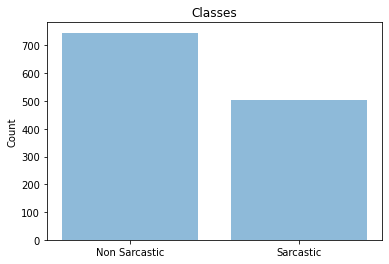

In [ ]:
# bar representation
objects = ('Non Sarcastic', 'Sarcastic')
y_pos = np.arange(len(objects))
performance = [tweet_class.count('NO'), tweet_class.count('YES')]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Classes')

plt.show()

In [ ]:
# feature vector
# 1. char n-grams (1-3)
# 2. word n-grams (1-2)
# 3. punctuations (count of each punctuation mark)
# 4. laugh words ("lmao", "lol", "haha", "rofl", "lel", "hehehe", "lolol")
# 5. intensifiers (number of intensifiers in a tweet)
# 6. negation words (number of negation words in a tweet)
# 7. (i) number of characters present in the tweet (ii) number of words in the tweet 
# (iii) average word length in the tweet
# 8. hashtags -> (split text added to preprocessed token list)
# 9. emoticons (2 ways): (i) replace emoticons with respective keywords. (ii) build emoticon feature vector

In [ ]:
# emoticon feature vector. presence or absence of various emoticons in the tweet

all_emoticons1 = \
	[	':-)', ':)', '(:', '(-:',\
		':-D', ':D', 'X-D', 'XD', 'xD',\
		'<3', ':\*',\
		';-)', ';)', ';-D', ';D', '(;', '(-;',\
		':-(', ':(',\
		':,(', ':\'(', ':"(', ':((',\
		':-P', ':P', ':p', ':-p',\
	]

def add_emoticon_features():
    emoticon_feature_vector = []
    for i in range(len(all_emoticons1)):
        temp_vector = []
        for emoticons in df['Emoticons']:
            if all_emoticons1[i] in emoticons:
                temp_vector.append(1)
            else:
                temp_vector.append(0)

        emoticon_feature_vector.append(temp_vector)
    
    return emoticon_feature_vector

emoticon_feature_vector = add_emoticon_features()
emoticon_feature_vector = np.array(np.transpose(emoticon_feature_vector))
emoticon_feature_vector.shape

(1250, 27)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

all_tokens = df['Preprocessed Tokens']
all_tweets = df['Preprocessed Tweets']

# char n grams 
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(1,3),
    max_features=500)
char_vectorizer.fit(all_tweets)
char_features = char_vectorizer.transform(all_tweets)

# word n grams 
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 3),
    max_features=500)
word_vectorizer.fit(all_tweets)
word_features = word_vectorizer.transform(all_tweets)

char_features = char_features.todense()
word_features = word_features.todense()

print(char_features.shape, word_features.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:520: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'stop_words' will not be used"


(1250, 500) (1250, 500)


In [ ]:
n_for_char = 3
n_for_word = 2

# get character n-grams (n=1-3) for a tweet
def get_char_n_grams(tweet):
    char_n_grams = []
    for i in range(1, n_for_char + 1):
        char_i_grams = [tweet[j:j+i] for j in range(len(tweet) - (i-1))]
        char_n_grams.extend(char_i_grams)
    return char_n_grams

# get word n-grams (n=1-2) for a tweet
def get_word_n_grams(tokens):
    word_n_grams = []
    for i in range(1, n_for_word + 1):
        word_i_grams = [" ".join(tokens[j:j+i]) for j in range(len(tokens) - (i-1))]
        word_n_grams.extend(word_i_grams)
    return word_n_grams

In [ ]:
# all character n-grams for values of n ranging from 1 to 3. consider only those n-grams which occur at least 10
# times in the dataset
char_n_grams_index = {}
word_n_grams_index = {}

def get_all_char_n_grams(all_tweets):
    char_n_grams = []
    n_grams_count = {}
    for tweet in all_tweets:
        char_i_grams = get_char_n_grams(tweet)
        for i_gram in char_i_grams:
            if i_gram in n_grams_count:
                n_grams_count[i_gram] += 1
            else:
                n_grams_count[i_gram] = 1
    
    for i_gram, count in n_grams_count.items():
        if count >= 10:
            char_n_grams.append(i_gram)
    
    return char_n_grams

# all word n-grams for values of n ranging from 1 to 2. consider only those n-grams which occur at least 10
# times in the dataset
def get_all_word_n_grams(all_tokens):
    word_n_grams = []
    n_grams_count = {}
    for tokens in all_tokens:
        word_i_grams = get_word_n_grams(tokens)
        for i_gram in word_i_grams:
            if i_gram in n_grams_count:
                n_grams_count[i_gram] += 1
            else:
                n_grams_count[i_gram] = 1

        for i_gram, count in n_grams_count.items():
            if count >= 10:
                word_n_grams.append(i_gram)

    return word_n_grams

all_char_n_grams = list(set(get_all_char_n_grams(all_tweets)))
all_word_n_grams = list(set(get_all_word_n_grams(all_tokens)))
print(len(all_char_n_grams))
print(len(all_word_n_grams))

2124
354


In [ ]:
# char n gram feature vector
def add_char_n_gram_features():
    char_feature_vector = []
    for char_i_gram in all_char_n_grams:
        temp_vector = []
        for tweet in all_tweets:
            char_n_grams = get_char_n_grams(tweet)
            if char_i_gram in char_n_grams:
                temp_vector.append(1)
            else:
                temp_vector.append(0)

        char_feature_vector.append(temp_vector)
    
    return char_feature_vector

char_feature_vector = add_char_n_gram_features()
char_feature_vector = np.array(np.transpose(char_feature_vector))
print(char_feature_vector.shape)

(1250, 2124)


In [ ]:
# word n gram feature vector
def add_word_n_gram_features():
    word_feature_vector = []
    for word_i_gram in all_word_n_grams:
        temp_vector = []
        for tokens in all_tokens:
            word_n_grams = get_word_n_grams(tokens)
            if word_i_gram in word_n_grams:
                temp_vector.append(1)
            else:
                temp_vector.append(0)
        
        word_feature_vector.append(temp_vector)
      
    return word_feature_vector

word_feature_vector = add_word_n_gram_features()
word_feature_vector = np.array(np.transpose(word_feature_vector))
print(word_feature_vector.shape)

(1250, 354)


In [ ]:
feat_df = pd.DataFrame(data=np.concatenate((char_feature_vector, word_feature_vector), axis=1))
feat_df.shape

(1250, 2478)

In [ ]:
feat_df.to_csv('/content/drive/My Drive/Data Files/code-mixed analysis data/features.csv', sep=',')

In [ ]:
feat_df = pd.read_csv('/content/drive/My Drive/Data Files/code-mixed analysis data/features.csv')
feat_df.shape

(1250, 2479)

In [ ]:
# count occurences of "lol", "lmao", "hahaha", "hehehe"
laugh_words = ["lol", "lolol", "lololol", "loll", "lolll", "lollll", "looll", "loolll",
               "lmao", "lmaoo", "lmaooo", "lmaoooo", "haha", "hahah", "hahaha", 
               "hahahah", "hahahaha", "bahaha", "bahahah", "bahahaha", "bwahahaha", 
               "hehe", "heheh", "hehehe", "heheheh", "hehehehe"]

def get_laugh_words_count(tokens):
    count = 0
    for token in tokens:
        if token in laugh_words:
            count = count + 1
    
    return count

laugh_words_count = df['Preprocessed Tokens'].apply(lambda x: get_laugh_words_count(x))

In [ ]:
# count occurrences of intensifiers
intensifiers = ["amazingly", "astoundingly", "awful", "bare", "bloddy", "crazy", "dead", 
                "colossally", "especially", "excptionally", "excessively", "extremely", "extraodinarily",
                "fantastically", "frightfully", "fucking", "fully", "hella", "incredibly", "insanely",
                "literally", "mad", "mightly", "most", "outrageously", "phenomenally", "precious", "quite", 
                "radically", "rather", "real", "really", "remarkably", "ridicously", "right", "sick", "so",
                "somewhat", "strikingly", "super", "supremely", "surpassingly", "terribly", "terrifically",
                "too", "totally", "veritable", "very", "wicked"]

# partial matching to be done
# wordnet synonyms

def get_intensifiers_count(tokens):
    count = 0
    for token in tokens:
        if token in intensifiers:
            count = count + 1
    return count

# def get_intensifiers_count(tokens):
#     count = 0
#     for token in tokens:
#       highest = process.extractOne(token, intensifiers)
#         if highest[1] > 90:
#             count = count + 1
#     return count   

intensifiers_count = df['Preprocessed Tokens'].apply(lambda x: get_intensifiers_count(x))

In [ ]:
# count occurrences of negations
negations = ["never", "no", "nothing", "nowhere", "noone", "none", "not", "havent","have not", "hasnt","has not",
             "hadnt","had not", "cant","cannot","couldnt", "could not","shant","shall not", "shouldnt","should not", 
             "wont","will not","wouldnt","would not", "dont","do not","doesnt","does not", "didnt","did not", "isnt","is not", 
             "arent","are not", "aint", "am not", "may not", "might not", "wasnt","was not","werent", "were not"]

#contracted forms
def get_negations_count(tokens):
    count = 0
    for token in tokens:
        if token in negations:
            count = count + 1
    
    return count

negations_count = df['Preprocessed Tokens'].apply(lambda x: get_negations_count(x))

In [ ]:
# number of characters present in the tweet
def get_char_count(tokens):
    tweet = " ".join(tokens)
    return len(tweet)

# number of words in a tweet
def get_word_count(tokens):
    return len(tokens)

# punctuation count
def get_punct_count(tokens):
    tweet = ""
    for i in range(len(tokens)):
        if tokens[i][0] == '#' or tokens[i][0] == '@' or 'pic.twitter.com' in tokens[i] or tokens[i] in df['Emoticons'][i]:
            continue
        tweet = tweet + " " + tokens[i]
        
    tweet = tweet.strip()
    return len("".join(_ for _ in tweet if _ in string.punctuation))


char_count = df['Preprocessed Tokens'].apply(lambda x: get_char_count(x))
word_count = df['Preprocessed Tokens'].apply(lambda x: get_word_count(x))
word_density = char_count/word_count
punct_count = df['Tokens'].apply(lambda x: get_punct_count(x))

In [ ]:
features1 = np.concatenate((char_feature_vector, word_feature_vector), axis=1)
features2 = np.vstack((laugh_words_count, intensifiers_count, negations_count, char_count, word_count, 
             word_density, punct_count))

In [ ]:
# feature selection
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel, f_classif

def feature_selection(features, y):
    model = SelectKBest(score_func=chi2, k=500)
    fit = model.fit(features, y)
    new_features = fit.transform(features)
    return features.tolist()

new_features = feature_selection(features, df['Tweet Class'])



> **ML** **MODELS**



In [ ]:
X = features1
y = df['Class Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,random_state=1)

In [ ]:
# svc
from sklearn.svm import SVC

svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
svm_probs = svm.predict_proba(X_test)[:, 1]
print(accuracy_score(y_test,y_pred))
print(len(y_pred))

0.9361702127659575
188


In [ ]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred, digits=4))

[[102   6]
 [  6  74]]
              precision    recall  f1-score   support

           0     0.9444    0.9444    0.9444       108
           1     0.9250    0.9250    0.9250        80

    accuracy                         0.9362       188
   macro avg     0.9347    0.9347    0.9347       188
weighted avg     0.9362    0.9362    0.9362       188



In [ ]:
# naive bayes
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
gnb_probs = gnb.predict_proba(X_test)[:, 1]
print(accuracy_score(y_test,y_pred))

0.8617021276595744


In [ ]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred, digits=4))

[[101   7]
 [ 19  61]]
              precision    recall  f1-score   support

           0     0.8417    0.9352    0.8860       108
           1     0.8971    0.7625    0.8243        80

    accuracy                         0.8617       188
   macro avg     0.8694    0.8488    0.8551       188
weighted avg     0.8652    0.8617    0.8597       188



In [ ]:
# random forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, bootstrap = True, max_features = 'sqrt')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
# Probabilities for each class
rf_probs = rf.predict_proba(X_test)[:, 1]
print(accuracy_score(y_test,y_pred))

0.9680851063829787


In [ ]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[103   5]
 [  1  79]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       108
           1       0.94      0.99      0.96        80

    accuracy                           0.97       188
   macro avg       0.97      0.97      0.97       188
weighted avg       0.97      0.97      0.97       188



In [ ]:
# knn
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.925531914893617


In [ ]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[103   5]
 [  9  71]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       108
           1       0.93      0.89      0.91        80

    accuracy                           0.93       188
   macro avg       0.93      0.92      0.92       188
weighted avg       0.93      0.93      0.93       188



In [ ]:
# multinomial NB
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred = mnb.predict(X_test)
mnb_probs = mnb.predict_proba(X_test)[:, 1]
print(accuracy_score(y_test,y_pred))

0.9574468085106383


In [ ]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[103   5]
 [  3  77]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       108
           1       0.94      0.96      0.95        80

    accuracy                           0.96       188
   macro avg       0.96      0.96      0.96       188
weighted avg       0.96      0.96      0.96       188



In [ ]:
# logistic regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
logreg_probs = logreg.predict_proba(X_test)[:, 1]
print(accuracy_score(y_test,y_pred))

0.9574468085106383


In [ ]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred, digits=4))

[[103   5]
 [  3  77]]
              precision    recall  f1-score   support

           0     0.9717    0.9537    0.9626       108
           1     0.9390    0.9625    0.9506        80

    accuracy                         0.9574       188
   macro avg     0.9554    0.9581    0.9566       188
weighted avg     0.9578    0.9574    0.9575       188



In [ ]:
# xgboost
from xgboost import XGBClassifier

xg = XGBClassifier()
xg.fit(X_train, y_train)
y_pred = xg.predict(X_test)
xg_probs = xg.predict_proba(X_test)[:, 1]
print(accuracy_score(y_test,y_pred))

0.9574468085106383


In [ ]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred, digits=4))

[[103   5]
 [  3  77]]
              precision    recall  f1-score   support

           0     0.9717    0.9537    0.9626       108
           1     0.9390    0.9625    0.9506        80

    accuracy                         0.9574       188
   macro avg     0.9554    0.9581    0.9566       188
weighted avg     0.9578    0.9574    0.9575       188



In [ ]:
# adaboost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200
)
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)
ada_probs = ada.predict_proba(X_test)[:, 1]
print(accuracy_score(y_test,y_pred))

0.9468085106382979


In [ ]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred, digits=4))

[[102   6]
 [  4  76]]
              precision    recall  f1-score   support

           0     0.9623    0.9444    0.9533       108
           1     0.9268    0.9500    0.9383        80

    accuracy                         0.9468       188
   macro avg     0.9445    0.9472    0.9458       188
weighted avg     0.9472    0.9468    0.9469       188





> **DL MODELS**



In [ ]:
from tensorflow.python.keras.preprocessing.text import one_hot
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.core import Activation, Dropout, Dense
from tensorflow.python.keras.layers import Flatten, GlobalMaxPooling1D, Bidirectional
from tensorflow.python.keras.layers.recurrent import LSTM
from tensorflow.python.keras.layers.embeddings import Embedding
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.callbacks import EarlyStopping

from tensorflow.python.keras.layers import Input, CuDNNLSTM, CuDNNGRU, Conv1D
from tensorflow.python.keras.layers import GlobalMaxPool1D, GlobalAveragePooling1D
from tensorflow.python.keras.layers import Input, Conv2D, MaxPool2D, concatenate
from tensorflow.python.keras.layers import Reshape, Concatenate, SpatialDropout1D
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Layer, InputSpec
from tensorflow.python.keras import initializers, regularizers, constraints, optimizers, layers

from tensorflow.python.keras.layers import *
from tensorflow.python.keras.models import *
from tensorflow.python.keras.initializers import *
from tensorflow.python.keras.optimizers import *
import tensorflow.python.keras.backend as K
from tensorflow.python.keras.callbacks import *
import tensorflow as tf

from data_helpers import BPE

In [ ]:
pip install git+git://github.com/qevo/py_data_helper.git

  Cloning git://github.com/qevo/py_data_helper.git to /tmp/pip-req-build-aljph9i6
  Running command git clone -q git://github.com/qevo/py_data_helper.git /tmp/pip-req-build-aljph9i6
  Created wheel for data-helper: filename=data_helper-0.2.3-cp36-none-any.whl size=6682 sha256=20644c6a90f210ff23b4b8990e3bddea0c1562243d819f27ff94b18718aa7645
  Stored in directory: /tmp/pip-ephem-wheel-cache-qu26iw9h/wheels/ac/95/cc/b588c9a7148810267975c68ab54c447dddfdd2ba26b3a1ed01
Successfully built data-helper


In [ ]:
X = df['Preprocessed Tweets']
y = df['Class Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,random_state=1)

Word Embeddings

In [ ]:
# tokenizing using Keras Tokenizer
num_words = 30000
tokenizer = Tokenizer(num_words=num_words, lower=True, split=' ')
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print(word_index)

Found 13430 unique tokens.
{'hai': 1, 'ki': 2, 'ko': 3, 'politics': 4, 'ke': 5, 'talaq': 6, 'bhi': 7, 'se': 8, 'triple': 9, 'cricket': 10, 'ka': 11, 'aur': 12, 'ho': 13, 'nahi': 14, 'k': 15, 'ye': 16, 'hi': 17, 'bollywood': 18, 'kar': 19, 'hain': 20, 'aap': 21, 'kya': 22, 'liye': 23, 'kuch': 24, 'h': 25, 'par': 26, 'koi': 27, 'jo': 28, 'na': 29, 'ek': 30, 'bhai': 31, 'ab': 32, 'log': 33, 'ne': 34, 'rahe': 35, 'mein': 36, 'pe': 37, 'aaj': 38, 'desh': 39, 'baat': 40, 'raha': 41, 'nhi': 42, 'ji': 43, 'sab': 44, 'tha': 45, 'main': 46, 'toh': 47, 'wo': 48, 'sir': 49, 'i': 50, 'gaya': 51, 'hota': 52, 'jab': 53, 'kiya': 54, 'apni': 55, 'tum': 56, 'karte': 57, 'a': 58, 'b': 59, 'mai': 60, 'rahi': 61, 'abhi': 62, 'kabhi': 63, 'apne': 64, 'karne': 65, 'chahiye': 66, 'pakistan': 67, 'india': 68, 's': 69, 'modi': 70, 'sirf': 71, 'tu': 72, 'muslim': 73, 'jaise': 74, 'hoga': 75, 'kisi': 76, 'diya': 77, 'tak': 78, 'hum': 79, 'n': 80, 'ya': 81, 'aa': 82, 'karo': 83, 'kaam': 84, 'de': 85, 'agar': 86, '

In [ ]:
# adding 1 because of reserved 0 index for padding
vocab_size = len(word_index) + 1

maxlen = 120

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
# use GloVe embeddings to create the feature matrix
# load the GloVe word embeddings and create a dictionary that will contain words as keys and their corresponding embedding list as values
embeddings_dictionary = dict()
glove_file = open('/content/drive/My Drive/Data Files/depression analysis data/glove.6B.300d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [ ]:
# create an embedding matrix where each row number will correspond to the index of the word in the corpus 
# the matrix will have 300 columns where each column will contain the GloVe word embeddings for the words in our corpus
EMBEDDING_DIM = 300
embedding_matrix = [[0]*EMBEDDING_DIM]*vocab_size
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
# attention Layer
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    
class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [ ]:
# bidirectional lstm with attention layer model
def model_lstm(embedding_matrix):
    inp = Input(shape=(maxlen,))
    x = Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], trainable=True)(inp)
    x = Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(x)
    # x = AttentionWithContext()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.30)(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.30)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

model_lstm = model_lstm(np.array(embedding_matrix))
model_lstm.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 120)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 120, 300)          4029300   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 120, 512)          1140736   
_________________________________________________________________
dense_3 (Dense)              (None, 120, 128)          65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 120, 128)          0         
_________________________________________________________________
dense_4 (Dense)              (None, 120, 128)          16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 120, 128)          0   

In [ ]:
# save the best model and early stopping
# saveBestModel = keras.callbacks.ModelCheckpoint(path+'/model/best_model.hdf5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

# Fit the model
history = model_lstm.fit(X_train, y_train, batch_size=1000, epochs=2, validation_split=0.15, callbacks=[earlyStopping])

Epoch 1/2
4/4 [==============================] - 73s 18s/step - loss: 0.6234 - accuracy: 0.8761 - val_loss: 0.4469 - val_accuracy: 0.9030
Epoch 2/2
4/4 [==============================] - 72s 18s/step - loss: 0.3998 - accuracy: 0.9014 - val_loss: 0.3612 - val_accuracy: 0.9030


In [ ]:
# Final evaluation of the model
metrics = model_lstm.evaluate(X_test, y_test)
print("Loss", metrics[0])
print("Accuracy:", metrics[1])

25/25 [==============================] - 8s 309ms/step - loss: 0.3319 - accuracy: 0.9175
Loss 0.331880122423172
Accuracy: 0.9175127148628235


In [ ]:
y_pred_test = model.predict(X_test, batch_size=128)
y_pred_bool_test = y_pred_test > 0.5

print(classification_report(y_test, y_pred_bool_test))

In [ ]:
# cnn model
def model_cnn(embedding_matrix):
    inp = Input(shape=(maxlen,))
    x = Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], trainable=True)(inp)
    x = SpatialDropout(0.3)(x)
    x = Convolution1D(100, 3, activation="relu")(x)
    x = GlobalMaxPool1D()(x)
    # x = AttentionWithContext()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.30)(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.30)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

model_cnn = model_cnn(np.array(embedding_matrix))
model_cnn.summary()

In [ ]:
# save the best model and early stopping
# saveBestModel = keras.callbacks.ModelCheckpoint(path+'/model/best_model.hdf5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

# Fit the model
history = model_cnn.fit(X_train, y_train, batch_size=1000, epochs=2, validation_split=0.15, callbacks=[earlyStopping])

In [ ]:
# Final evaluation of the model
metrics = model_cnn.evaluate(X_test, y_test)
print("Loss", metrics[0])
print("Accuracy:", metrics[1])

In [ ]:
y_pred_test = model.predict(X_test, batch_size=128)
y_pred_bool_test = y_pred_test > 0.5

print(classification_report(y_test, y_pred_bool_test))

Character Embeddings

In [ ]:
# character level tokenizer
tokenizer = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
tokenizer.fit_on_texts(X_train)

# if you already have a character list, then replace the tokenizer.word_index
# construct a new vocabulary 
alphabet="abcdefghijklmnopqrstuvwxyz0123456789 ,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
char_dict = {}
for i, char in enumerate(alphabet):
    char_dict[char] = i + 1
    
# use char_dict to replace the tokenizer.word_index
tokenizer.word_index = char_dict.copy() 
# add 'UNK' to the vocabulary 
tokenizer.word_index[tokenizer.oov_token] = max(char_dict.values()) + 1

# convert string to index 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# padding
X_train = pad_sequences(X_train, maxlen=1014, padding='post')
X_test = pad_sequences(X_test, maxlen=1014, padding='post')

# convert to numpy array
X_train = np.array(X_train, dtype='float32')
X_test = np.array(X_test, dtype='float32')

print(tokenizer.word_index)

vocab_size = len(tokenizer.word_index) + 1 
print(vocab_size)

In [ ]:
embedding_weights = [] #(71, 70)
embedding_weights.append(np.zeros(vocab_size)) # first row is pad

for char, i in tokenizer.word_index.items(): # from index 1 to 70
    onehot = np.zeros(vocab_size)
    onehot[i-1] = 1
    embedding_weights.append(onehot)
embedding_weights = np.array(embedding_weights)

print(embedding_weights.shape) # first row all 0 for PAD, 69 char, last row for UNK
print(embedding_weights)

In [ ]:
# char embeddings with cnn
input_size = 1014
embedding_size = 69
conv_layers = [[256, 7, 3], 
               [256, 7, 3], 
               [256, 3, -1], 
               [256, 3, -1], 
               [256, 3, -1], 
               [256, 3, 3]]
fully_connected_layers = [1024, 1024]

def model_char_embeddings_cnn():
    inputs = Input(shape=(input_size,), name='input', dtype='int64')  # shape=(?, 1014)
    x = Embedding(vocab_size, embedding_size, input_length=input_size, weights=[embedding_weights])(inputs)
    for filter_num, filter_size, pooling_size in conv_layers:
        x = Conv1D(filter_num, filter_size)(x) 
        x = Activation('relu')(x)
        if pooling_size != -1:
            x = MaxPooling1D(pool_size=pooling_size)(x) # final shape=(none, 34, 256)
    x = Flatten()(x) # (none, 8704)
    for dense_size in fully_connected_layers:
        x = Dense(dense_size, activation='relu')(x) # dense_size == 1024
        x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    # build model
    model = Model(inputs=inputs, outputs=predictions)
    model = model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # adam, categorical_crossentropy
    return model

model_char_embeddings_cnn = model_char_embeddings_cnn()
model_char_embeddings_cnn.summary()

In [ ]:
# save the best model and early stopping
# saveBestModel = keras.callbacks.ModelCheckpoint(path+'/model/best_model.hdf5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

# Fit the model
history = model_char_embeddings_cnn.fit(X_train, y_train, batch_size=1000, epochs=2, validation_split=0.15, callbacks=[earlyStopping])

In [ ]:
# final evaluation of the model
metrics = model_cnn.evaluate(X_test, y_test)
print("Loss", metrics[0])
print("Accuracy:", metrics[1])

In [ ]:
# CMSA architecture
# 1. sub-word level representations with CNN
# 2. parallel encoder network consisting of two BiLSTMs with attention mechanism
# 3. feature network

Sub-word Embeddings

In [ ]:
# sub-word level representation
# convert string to subword, this process may take several minutes
bpe = BPE("/content/drive/My Drive/Data Files/code-mixed analysis data/en.wiki.bpe.op25000.vocab.txt")
X_train = [bpe.encode(sentence) for sentence in X_train]
X_test = [bpe.encode(sentence) for sentence in X_test]

# build vocab, {token: index}
vocab = {}
for i, token in enumerate(bpe.words):
    vocab[token] = i + 1

# convert subword to index, function version 
def subword2index(texts, vocab):
    sentences = []
    for s in texts:
        s = s.split()
        one_line = []
        for word in s:
            if word not in vocab.keys():
                one_line.append(vocab['unk'])
            else:
                one_line.append(vocab[word])
        sentences.append(one_line)
    return sentences

# sonvert train and test 
X_train = subword2index(X_train, vocab)
X_test = subword2index(X_test, vocab)

# padding
X_train = pad_sequences(X_train, maxlen=1014, padding='post')
X_test = pad_sequences(X_test, maxlen=1014, padding='post')

# convert to numpy array
X_train = np.array(X_train)
X_test = np.array(X_test)

In [ ]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format("/content/drive/My Drive/Data Files/code-mixed analysis data/en.wiki.bpe.op25000.d50.w2v.bin", 
                                          binary=True)

In [ ]:
embedding_dim = 50
embedding_weights = np.zeros((len(vocab) + 1, embedding_dim)) # (25001, 50)

for subword, i in vocab.items():
    if subword in model.vocab:
        embedding_vector = model[subword]
        if embedding_vector is not None:
            embedding_weights[i] = embedding_vector
    else:
        # print(subword) # print the subword in vocab but not in model
        continue

In [ ]:
# sub-word embeddings with cnn
input_size = 1014
embedding_size = 50
vocab_size = len(vocab)+1
conv_layers = [[256, 7, 3],
               [256, 7, 3],
               [256, 3, -1],
               [256, 3, -1],
               [256, 3, -1],
               [256, 3, 3]]
fully_connected_layers = [1024, 1024]

def model_subword_embeddings_cnn():
    inputs = Input(shape=(input_size,), name='input', dtype='int64')  # shape=(?, 1014)
    x = Embedding(vocab_size, embedding_size, input_length=input_size, weights=[embedding_weights])(inputs)
    for filter_num, filter_size, pooling_size in conv_layers:
        x = Conv1D(filter_num, filter_size)(x) 
        x = Activation('relu')(x)
        if pooling_size != -1:
            x = MaxPooling1D(pool_size=pooling_size)(x) # final shape=(none, 34, 256)
    x = Flatten()(x) # (none, 8704)
    for dense_size in fully_connected_layers:
        x = Dense(dense_size, activation='relu')(x) # dense_size == 1024
        x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    # build model
    model = Model(inputs=inputs, outputs=predictions)
    model = model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # adam, categorical_crossentropy
    return model

model_subword_embeddings_cnn = model_subword_embeddings_cnn()
model_subword_embeddings_cnn.summary()